# Test Map Styling

Compare basemaps (ESRI vs Google) and experiment with building overlay styling.

In [13]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx

from src.utils.config_loader import load_config, get_data_dir
from src.data_processing.load_boundaries import load_control_grid, load_subgrid

config = load_config()
data_dir = get_data_dir(config)
print(f"Data directory: {data_dir}")

Loaded local config overrides from config.local.yaml
Data directory: G:\Shared drives\TZ-CCT_RUBEV-0825\Data\1_Baseline\0.4_listing_geospatial


In [14]:
# Basemap providers
BASEMAPS = {
    "esri": cx.providers.Esri.WorldImagery,
    "google-satellite": "https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}",
    "google-hybrid": "https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
}

In [15]:
# Load data
buildings_path = data_dir / "01_input_data" / "base_layers" / "overture_buildings.parquet"
buildings = gpd.read_parquet(buildings_path)
print(f"Loaded {len(buildings):,} buildings")

# Load grid with counts
grid_path = data_dir / "02_outputs" / "building_counts" / "grid_1000m_building_counts.gpkg"
grid = gpd.read_file(grid_path)
print(f"Loaded {len(grid):,} grid cells")

# Ensure same CRS
if buildings.crs != grid.crs:
    buildings = buildings.to_crs(grid.crs)

Loaded 342,791 buildings
Loaded 1,115 grid cells


In [16]:
# Select a sample cell with good building count
id_col = "grid_id" if "grid_id" in grid.columns else "id"
sample_cell = grid.nlargest(10, "building_count").iloc[3]  # 4th highest
cell_id = sample_cell[id_col]
cell_geom = sample_cell.geometry
building_count = sample_cell["building_count"]

print(f"Sample cell: {cell_id}")
print(f"Building count: {building_count:,}")

# Get buildings in this cell
cell_buildings = buildings[buildings.geometry.intersects(cell_geom)]
print(f"Buildings in cell: {len(cell_buildings):,}")

Sample cell: G_0712_1190
Building count: 357
Buildings in cell: 357


## Compare Basemaps: ESRI vs Google

In [17]:
def plot_tile(ax, cell_geom, cell_buildings, basemap_source, title, style):
    """Plot a single tile with basemap and buildings."""
    # Convert to Web Mercator
    cell_gdf = gpd.GeoDataFrame(geometry=[cell_geom], crs=grid.crs).to_crs(epsg=3857)
    
    # Plot cell boundary
    cell_gdf.plot(
        ax=ax,
        facecolor="none",
        edgecolor=style.get("cell_color", "red"),
        linewidth=style.get("cell_linewidth", 3),
    )
    
    # Plot buildings
    if cell_buildings is not None and len(cell_buildings) > 0:
        cell_buildings_wm = cell_buildings.to_crs(epsg=3857)
        cell_buildings_wm.plot(
            ax=ax,
            facecolor=style.get("building_color", "yellow"),
            edgecolor=style.get("building_edge", "orange"),
            linewidth=style.get("building_linewidth", 0.5),
            alpha=style.get("building_alpha", 0.6),
        )
    
    # Set bounds
    minx, miny, maxx, maxy = cell_gdf.total_bounds
    buffer = (maxx - minx) * 0.1
    ax.set_xlim(minx - buffer, maxx + buffer)
    ax.set_ylim(miny - buffer, maxy + buffer)
    
    # Add basemap
    cx.add_basemap(ax, source=basemap_source, zoom="auto")
    
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_axis_off()

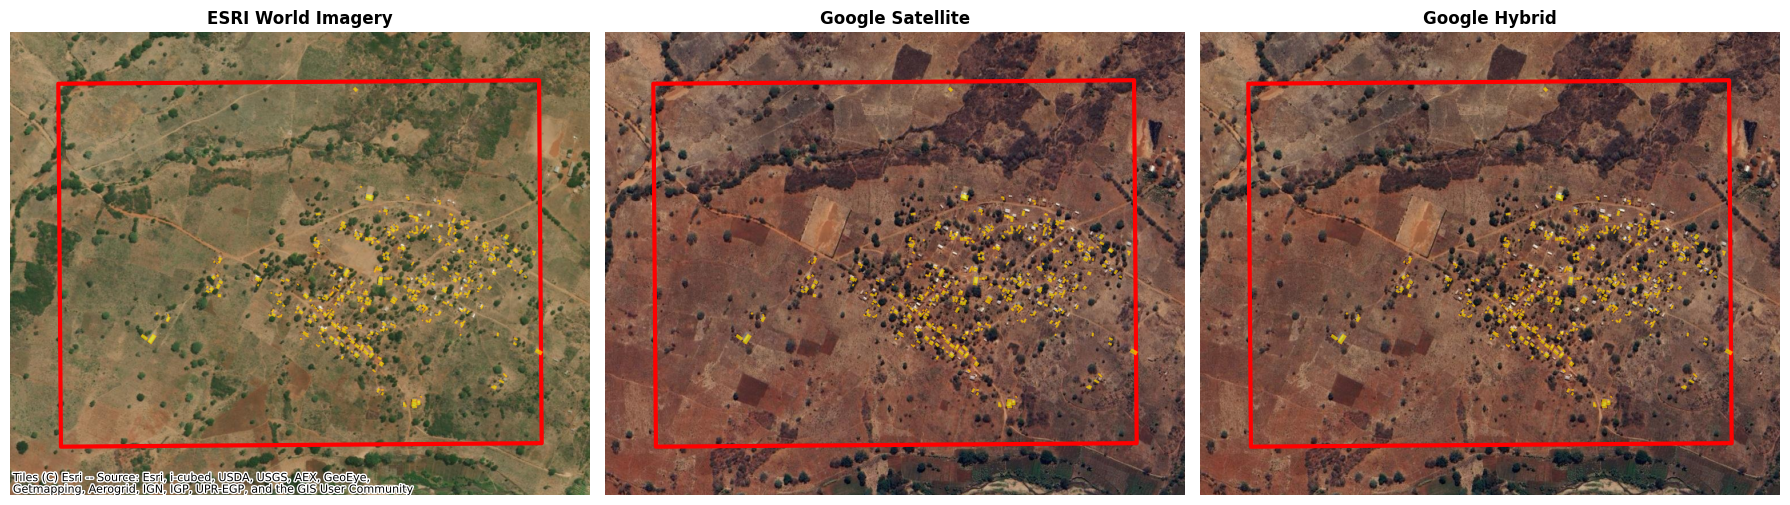

In [18]:
# Compare ESRI vs Google basemaps
style = {
    "building_color": "yellow",
    "building_edge": "orange",
    "building_alpha": 0.6,
    "building_linewidth": 0.5,
    "cell_color": "red",
    "cell_linewidth": 3,
}

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_tile(axes[0], cell_geom, cell_buildings, BASEMAPS["esri"], "ESRI World Imagery", style)
plot_tile(axes[1], cell_geom, cell_buildings, BASEMAPS["google-satellite"], "Google Satellite", style)
plot_tile(axes[2], cell_geom, cell_buildings, BASEMAPS["google-hybrid"], "Google Hybrid", style)

plt.tight_layout()
plt.show()

## Experiment with Building Styles

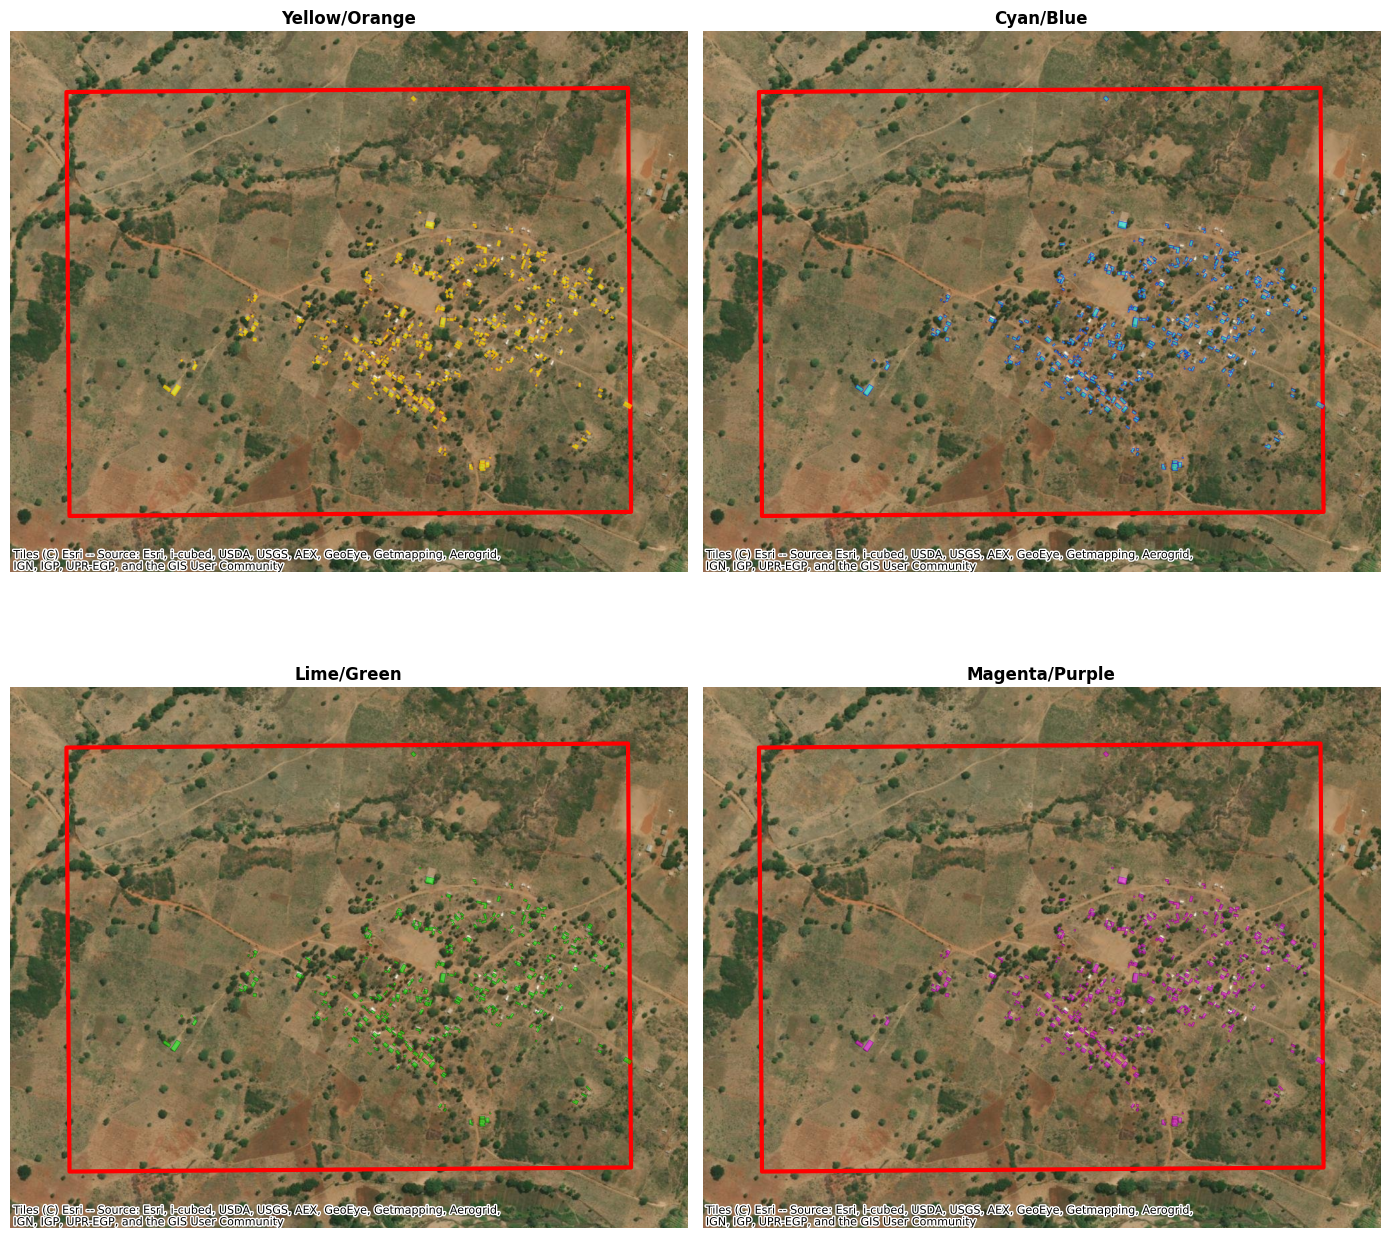

In [19]:
# Different building color schemes
styles = [
    {"building_color": "yellow", "building_edge": "orange", "building_alpha": 0.6, "name": "Yellow/Orange"},
    {"building_color": "cyan", "building_edge": "blue", "building_alpha": 0.5, "name": "Cyan/Blue"},
    {"building_color": "lime", "building_edge": "darkgreen", "building_alpha": 0.5, "name": "Lime/Green"},
    {"building_color": "magenta", "building_edge": "purple", "building_alpha": 0.5, "name": "Magenta/Purple"},
]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

for ax, s in zip(axes.flat, styles):
    style = {
        "building_color": s["building_color"],
        "building_edge": s["building_edge"],
        "building_alpha": s["building_alpha"],
        "building_linewidth": 0.5,
        "cell_color": "red",
        "cell_linewidth": 3,
    }
    plot_tile(ax, cell_geom, cell_buildings, BASEMAPS["esri"], s["name"], style)

plt.tight_layout()
plt.show()

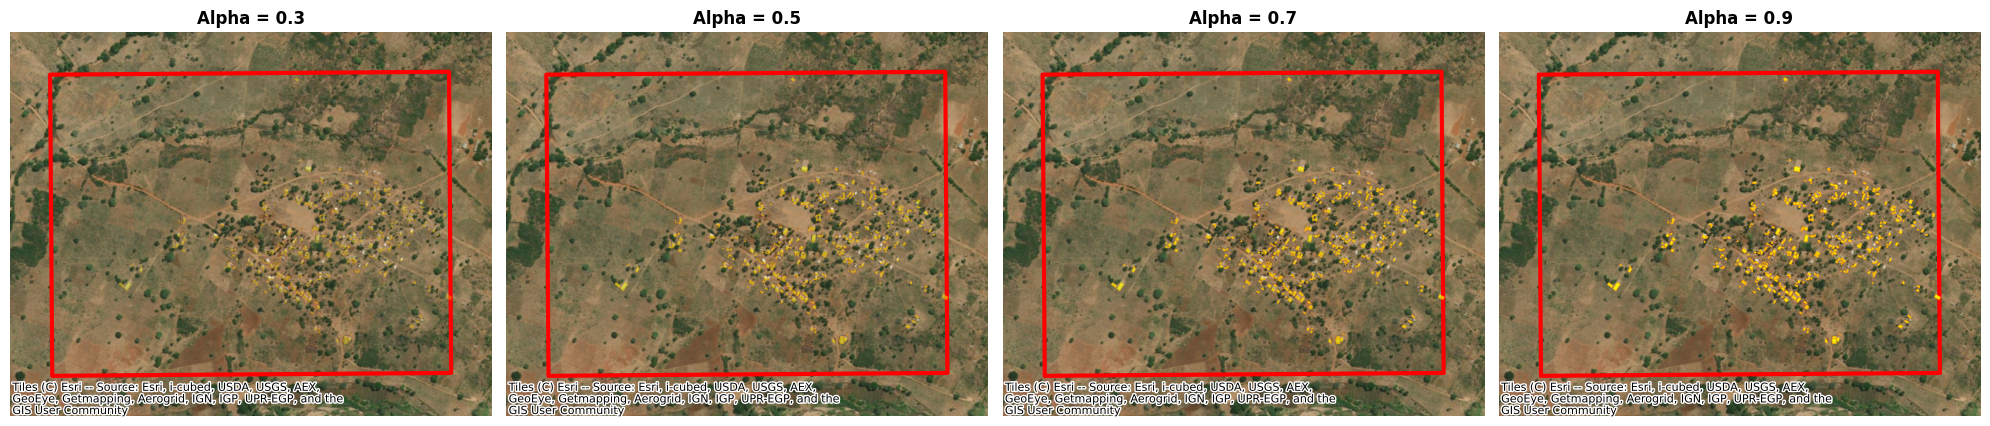

In [20]:
# Different transparency levels
alphas = [0.3, 0.5, 0.7, 0.9]

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for ax, alpha in zip(axes, alphas):
    style = {
        "building_color": "yellow",
        "building_edge": "orange",
        "building_alpha": alpha,
        "building_linewidth": 0.5,
        "cell_color": "red",
        "cell_linewidth": 3,
    }
    plot_tile(ax, cell_geom, cell_buildings, BASEMAPS["esri"], f"Alpha = {alpha}", style)

plt.tight_layout()
plt.show()

## Test on Multiple Cells

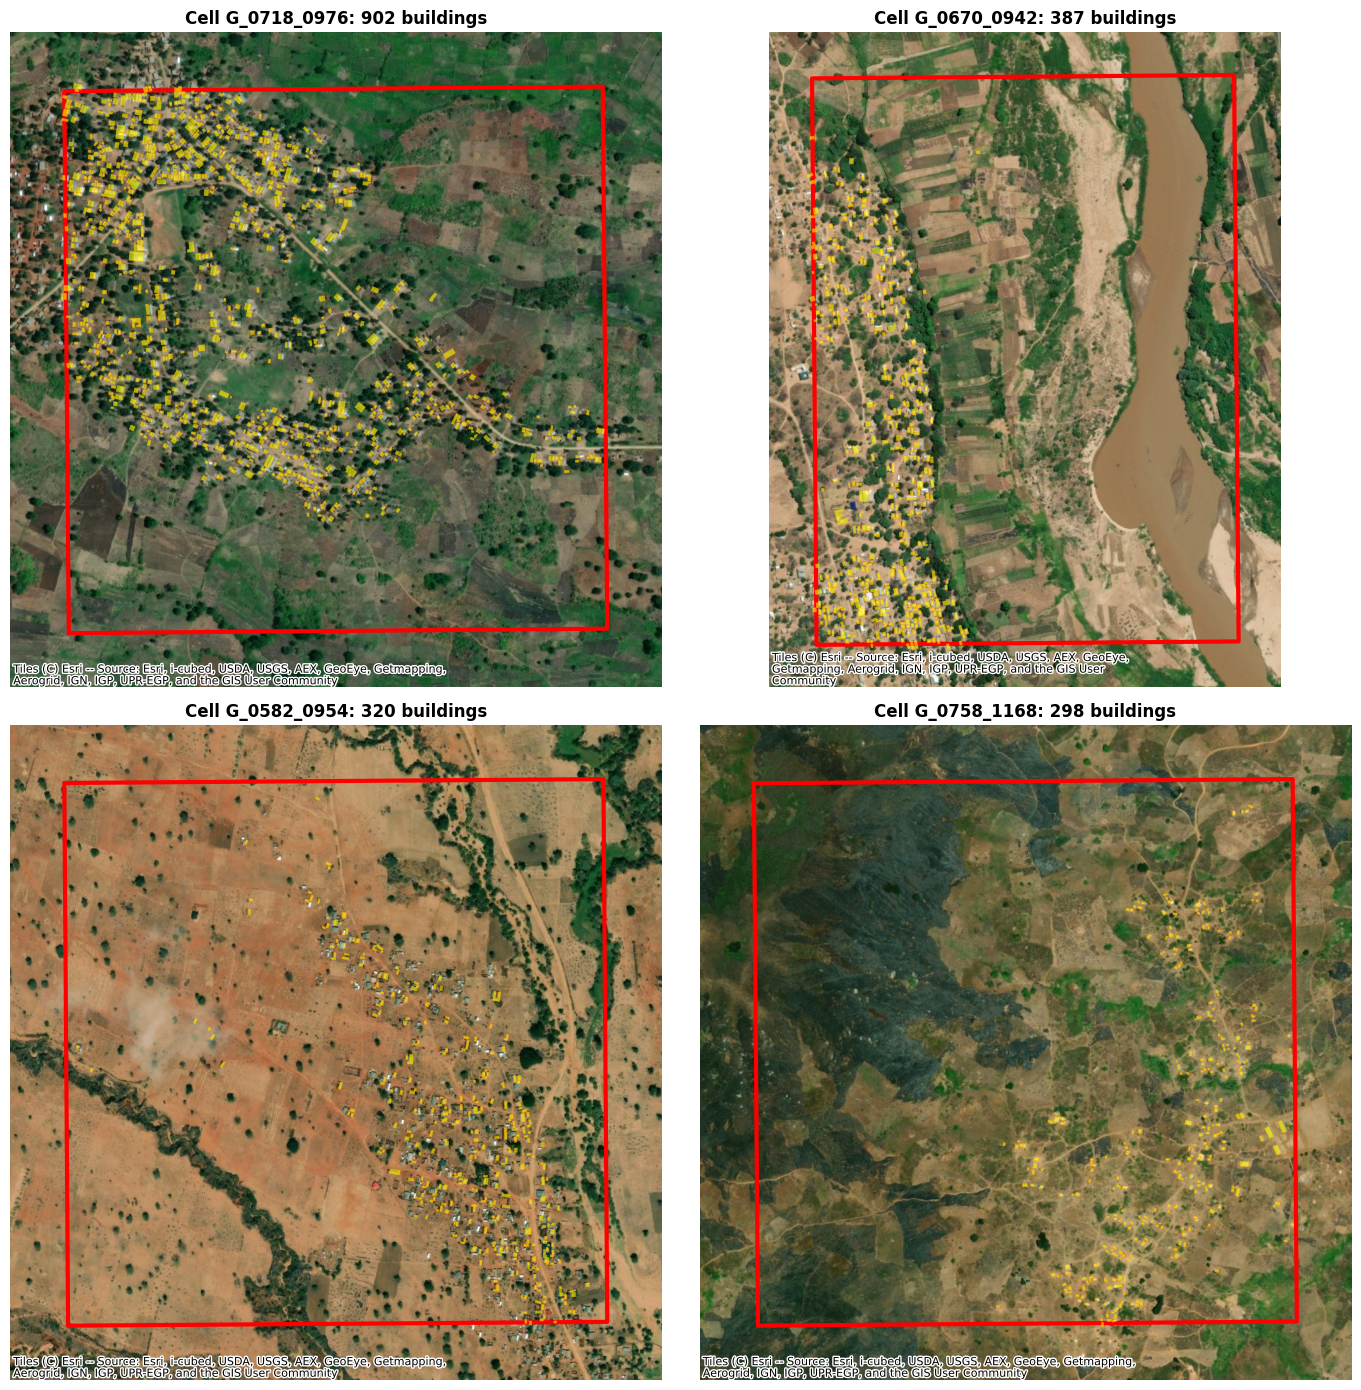

In [21]:
# Test on 4 different cells
test_cells = grid.nlargest(8, "building_count").iloc[::2]  # Every other from top 8

# Pick your preferred style
style = {
    "building_color": "yellow",
    "building_edge": "orange",
    "building_alpha": 0.6,
    "building_linewidth": 0.5,
    "cell_color": "red",
    "cell_linewidth": 3,
}

# Pick your preferred basemap
basemap = BASEMAPS["esri"]  # or "google-satellite" or "google-hybrid"

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

for ax, (_, cell) in zip(axes.flat, test_cells.iterrows()):
    c_id = cell[id_col]
    c_geom = cell.geometry
    c_count = cell["building_count"]
    c_buildings = buildings[buildings.geometry.intersects(c_geom)]
    
    plot_tile(ax, c_geom, c_buildings, basemap, f"Cell {c_id}: {c_count:,} buildings", style)

plt.tight_layout()
plt.show()

## Save Your Preferred Settings

Once you've found settings you like, use them in `generate_all_maps.py`:

```bash
python scripts/generate_all_maps.py --basemap esri --subgrid 500
```